# Introduction

This script offers two methods for obtaining OpenStreetMap (OSM) data:
- Option 1: Pre-processed .pbf File: You can download an OSM data extract in .pbf format from external sources like BBBike (https://extract.bbbike.org/) and use it directly with this script.
- Option 2: Automatic Data Extraction: Alternatively, you can input your desired coordinates directly into the script, and it will automatically fetch and process the OSM data for you.

To use option 2, follow these steps:
- Obtain 'osmconvert.exe' from the OSM Wiki (https://wiki.openstreetmap.org/wiki/Osmconvert#Download).
- Ensure that 'osmconvert.exe' is located in the same directory as this script.

By following these instructions, you'll be able to seamlessly extract and work with OSM data according to your needs.

# Input Data

## Option 1: Pre-processed .pbf File

Enter your file path for the .pbf file here if you want to use option 1. If you want to use option 2, enter None.

In [1]:
pbf_file = None

## Option 2: Automatic Data Extraction

Enter your coordinates here if you want to use option 2. If you want to use option 1, enter None.

In [2]:
bbox = (50.32709, 11.99152, 50.31720, 12.01289)  # (north, west, south, east)
crs = 'EPSG:25832' # 'EPSG:4326' is the coordinate system in which the OSM file is created, you may want to change it
filename = 'Example_region' # Name under which the file is saved

# Imports

In [3]:
#!pip install osmnx
#!pip install osmium
#!pip install osmium overpy

In [4]:
import logging
import sys
import re
import os
import importlib
import warnings
import math

import pandas as pd
import geopandas
import folium

import pyrosm
from pyrosm.data import sources

from shapely import geometry, ops

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.font_manager as font_manager

import contextily as cx

import numpy as np
import shapely
import osmnx as ox

import sys
import os
import glob
import re

from xml.etree.ElementTree import ElementTree
from xml.etree.ElementTree import Element
from xml.etree.ElementTree import SubElement
import xml.etree.ElementTree as ET

from PIL import Image

# Logging

In [5]:
logger = logging.getLogger()

logFileName= r"Example4.log"

loglevel = logging.DEBUG
logging.basicConfig(filename=logFileName
                        ,filemode='w'
                        ,level=loglevel
                        ,format="%(asctime)s ; %(name)-60s ; %(levelname)-7s ; %(message)s")

fileHandler = logging.FileHandler(logFileName)

logger.addHandler(fileHandler)

consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logging.Formatter("%(levelname)-7s ; %(message)s"))
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)

# Fetching OSM Data

## Checking the option

In [6]:
if pbf_file != None and bbox == None:
    Option1 = True
    Option2 = False
    print('Option 1 is executed')
elif pbf_file == None and bbox != None:
    Option1 = False
    Option2 = True 
    print('Option 2 is executed')
elif pbf_file != None and bbox != None or pbf_file == None and bbox == None:
    Option1 = False
    Option2 = False
    print('Please choose one option only')

Option 2 is executed


## Option 1

In [7]:
if Option1:
    osm = pyrosm.OSM(pbf_file)

## Option 2

In [8]:
import requests

def fetch_osm_data(bbox, output_osm):
    """
    Retrieves OSM data for the specified area and saves it in an .osm file.

    :param bbox: A tuple with the coordinates (north, west, south, east)
    :param output_osm: Path to the output file
    """
    north, west, south, east = bbox

    # Check the coordinates for validity
    if not (north >= south and west <= east):
        raise ValueError("The bounding box coordinates are invalid. Make sure that north >= south and west <= east.")

    # Define the Overpass API URL
    overpass_url = "http://overpass-api.de/api/interpreter"

    # Build the URL for the request
    query = f"""
    [out:xml];
    (
      node({south},{west},{north},{east});
      way({south},{west},{north},{east});
      relation({south},{west},{north},{east});
    );
    out body;
    """
    
    # Execute the request
    try:
        response = requests.post(overpass_url, data={'data': query})
        response.raise_for_status()  # If HTTP errors occur, an exception is thrown
        
        # Write the data to an .osm file
        with open(output_osm, 'wb') as f:
            f.write(response.content)
        print(f'Data successfully retrieved and saved in {output_osm}.')
    except requests.RequestException as e:
        print(f'Error in the request: {e}')

if Option2:
    osm_file = filename + '.osm'  # Output file for .osm 
    fetch_osm_data(bbox, osm_file)

Data successfully retrieved and saved in Example_region.osm.


In [9]:
import subprocess

def convert_osm_to_pbf(input_osm, output_pbf):
    """
    Converts an OSM file into a PBF file with osmconvert.exe.
    
    :param input_osm: Path to the input OSM file
    :param output_pbf: Path to the output PBF file
    """
    # Path to osmconvert.exe
    osmconvert_path = 'osmconvert.exe' 
    
    # Command to convert
    command = f'"{osmconvert_path}" {input_osm} -o={output_pbf}'
    
    try:
        # Execute the command
        subprocess.run(command, shell=True, check=True)
        print(f'Datei erfolgreich konvertiert: {output_pbf}')
    except subprocess.CalledProcessError as e:
        print(f'Fehler bei der Konvertierung: {e}')

if Option2: 
    pbf_file = filename + '.pbf'  
    convert_osm_to_pbf(osm_file, pbf_file)

Datei erfolgreich konvertiert: Example_region.pbf


In [10]:
if Option2:
    osm = pyrosm.OSM(pbf_file)

# View .pbf file

<Axes: >

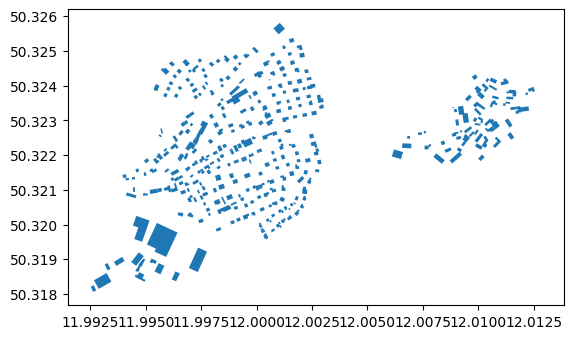

In [11]:
buildings = osm.get_buildings()
buildings.plot()

<Axes: >

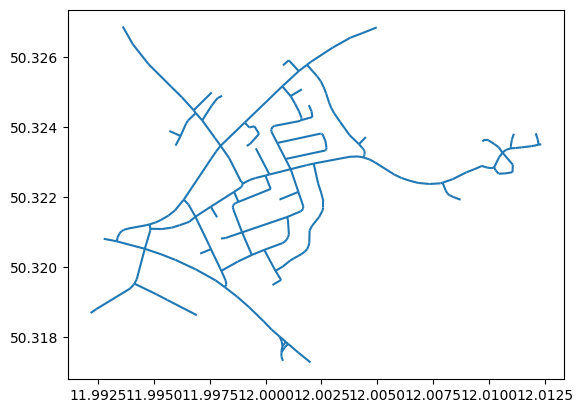

In [12]:
drive_net = osm.get_network(network_type="driving")
drive_net.plot()

<Axes: >

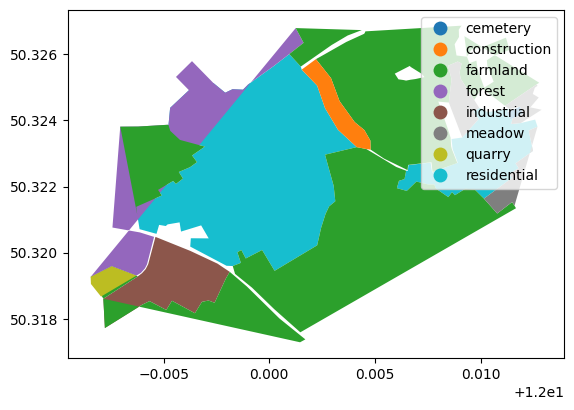

In [13]:
landuse = osm.get_landuse()
landuse.plot(column='landuse', legend=True) 

# Determine and view topology

In [14]:
nodes, edges = osm.get_network(nodes=True, network_type="driving")

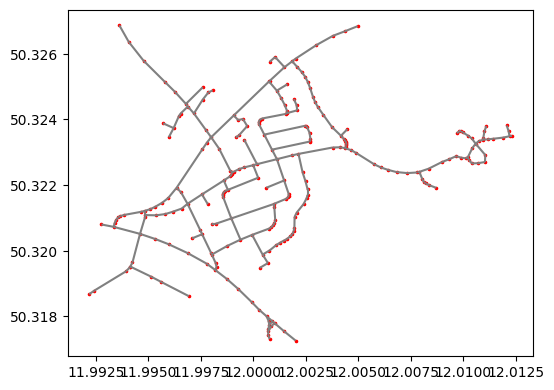

In [15]:
ax = edges.plot(figsize=(6,6), color="gray")
ax = nodes.plot(ax=ax, color="red", markersize=2.5)

In [16]:
G = osm.to_graph(nodes, edges, graph_type="networkx")

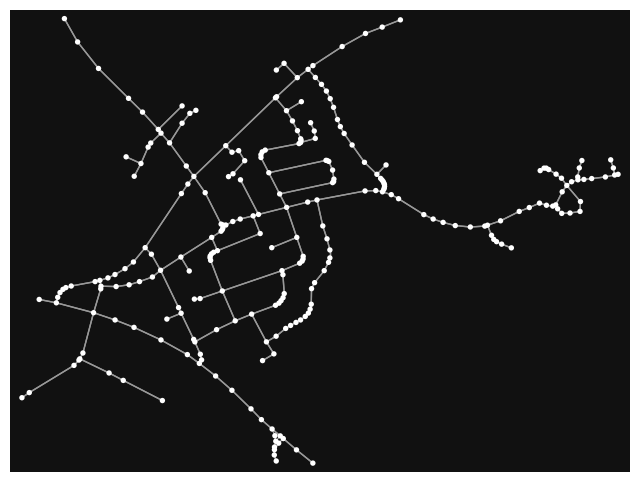

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [17]:
ox.plot_graph(G)

In [18]:
ox.folium.plot_graph_folium(G)

C:\Users\fabry\AppData\Local\Temp\ipykernel_3488\950166968.py:1: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.folium.plot_graph_folium(G)


# Exports

## Change CRS

In [19]:
nodes = nodes.to_crs(crs)
edges = edges.to_crs(crs)
buildings = buildings.to_crs(crs)

## Column calculation

In [20]:
nodes['NAME']=nodes['id'].astype('string')
nodes['XKOR']=nodes.centroid.x
nodes['YKOR']=nodes.centroid.y
nodes['ZKOR']=0.
nodes['BESCHREIBU']=''
nodes['IDREFERENZ']=nodes['id']

In [21]:
if not nodes[nodes.NAME.duplicated()].empty:
    logger.error('mehrfache Knotennamen!')

In [22]:
if max(nodes.NAME.str.len()) > 10:
    logger.error('Laenge von Roh-Knotennamen >10!')

ERROR   ; Laenge von Roh-Knotennamen >10!


In [23]:
edges['IDREFERENZ']=edges['id']
edges['BESCHREIBU']=edges.apply(lambda row: "OSM: Knoten {!s:s} -> Knoten {!s:s}; Länge: {:10.2f}".format(row['u'],row['v'],row['length']),axis=1)
edges['STRASSE']=edges.apply(lambda row: "{!s:s}".format(row['name']),axis=1)

In [24]:
buildings['IDREFERENZ']=buildings['id']
buildings['BESCHREIBU']=buildings.apply(lambda row: "{!s:s};{!s:s};{!s:s};{!s:s};{!s:s};{!s:s}".format( row['addr:city']
                                                                                                       ,row['addr:postcode']
                                                                                                       ,row['addr:street']
                                                                                                       ,row['addr:housenumber']
                                                                                                       ,row['name']
                                                                                                       ,row['building']),axis=1)

In [25]:
fwvb=buildings.copy(deep=True)

In [26]:
fwvb['W0']=fwvb.area

In [27]:
fwvb.set_geometry(fwvb.centroid,inplace=True)

## Shape

### Choose columns and write Shape

In [28]:
pbf_file_head,ext=os.path.splitext(pbf_file)
pbf_file_head,ext

('Example_region', '.pbf')

In [29]:
# Shift RL
xoff=2.
yoff=0.
zoff=0.

In [30]:
nodeColsShape=['NAME','IDREFERENZ','geometry']
#nodes['NAME']=nodes['NAME'].apply(lambda x: 'V-'+x)
nodes[nodeColsShape].to_file("{:s}Knoten.shp".format(pbf_file_head))

edgeColsShape=['BESCHREIBU','IDREFERENZ','STRASSE','geometry']
edges[edgeColsShape].to_file("{:s}Kanten.shp".format(pbf_file_head))

buildingsColsShape=['BESCHREIBU','IDREFERENZ','geometry']
buildings[buildingsColsShape].to_file("{:s}Gebaeude.shp".format(pbf_file_head))

fwvbColsShape=['BESCHREIBU','IDREFERENZ','W0','geometry']
fwvb[fwvbColsShape].to_file("{:s}FWVB.shp".format(pbf_file_head))

#nodes['NAME']=nodes['NAME'].apply(lambda x: 'R-'+x[2:])
nodes.set_geometry(nodes.geometry.translate(xoff=xoff,yoff=yoff,zoff=zoff))[nodeColsShape].to_file("{:s}KnotenRL.shp".format(pbf_file_head))
edges.set_geometry(edges.geometry.translate(xoff=xoff,yoff=yoff,zoff=zoff))[edgeColsShape].to_file("{:s}KantenRL.shp".format(pbf_file_head))   

#nodes['NAME']=nodes['NAME'].apply(lambda x: x[2:])

### ImportDef

#### Object types

In [31]:
root = Element('NewDataSet')

##### Knots

In [32]:
mT=SubElement(root,'MasterTable')
    
c=SubElement(mT,'Enabled')
c.text='true'
        
c=SubElement(mT,'nEntities')
rs,cs=nodes.shape 
c.text="{:d}".format(rs)
    
c=SubElement(mT,'ShapeName')
shpName="{:s}Knoten".format(pbf_file_head)
c.text=shpName
    
c=SubElement(mT,'GeometryType')
c.text='Point'       
    
c=SubElement(mT,'Sir3STable')
c.text='1'    
    
c=SubElement(mT,'Sir3STableName')
c.text='KNOT'        
    
c=SubElement(mT,'KVR')
c.text='1'    
    
c=SubElement(mT,'HAL')
c.text='false'      
    
c=SubElement(mT,'Import')
c.text='false'      
    
c=SubElement(mT,'Description')
c.text="generiert"

In [33]:
mT=SubElement(root,'MasterTable')
    
c=SubElement(mT,'Enabled')
c.text='true'
        
c=SubElement(mT,'nEntities')
rs,cs=nodes.shape 
c.text="{:d}".format(rs)
    
c=SubElement(mT,'ShapeName')
shpName="{:s}KnotenRL".format(pbf_file_head)
c.text=shpName
    
c=SubElement(mT,'GeometryType')
c.text='Point'       
    
c=SubElement(mT,'Sir3STable')
c.text='1'    
    
c=SubElement(mT,'Sir3STableName')
c.text='KNOT'        
    
c=SubElement(mT,'KVR')
c.text='2'    
    
c=SubElement(mT,'HAL')
c.text='false'      
    
c=SubElement(mT,'Import')
c.text='false'      
    
c=SubElement(mT,'Description')
c.text="generiert"

##### Edges

In [34]:
mT=SubElement(root,'MasterTable')
    
c=SubElement(mT,'Enabled')
c.text='true'
        
c=SubElement(mT,'nEntities')
rs,cs=edges.shape 
c.text="{:d}".format(rs)
    
c=SubElement(mT,'ShapeName')
shpName="{:s}Kanten".format(pbf_file_head)
c.text=shpName
    
c=SubElement(mT,'GeometryType')
c.text='PolyLine'       
    
c=SubElement(mT,'Sir3STable')
c.text='2'    
    
c=SubElement(mT,'Sir3STableName')
c.text='ROHR'        
    
c=SubElement(mT,'KVR')
c.text='1'    
    
c=SubElement(mT,'HAL')
c.text='false'      
    
c=SubElement(mT,'Import')
c.text='true'      
    
c=SubElement(mT,'Description')
c.text="generiert"

In [35]:
mT=SubElement(root,'MasterTable')
    
c=SubElement(mT,'Enabled')
c.text='true'
        
c=SubElement(mT,'nEntities')
rs,cs=edges.shape 
c.text="{:d}".format(rs)
    
c=SubElement(mT,'ShapeName')
shpName="{:s}KantenRL".format(pbf_file_head)
c.text=shpName
    
c=SubElement(mT,'GeometryType')
c.text='PolyLine'       
    
c=SubElement(mT,'Sir3STable')
c.text='2'    
    
c=SubElement(mT,'Sir3STableName')
c.text='ROHR'        
    
c=SubElement(mT,'KVR')
c.text='2'    
    
c=SubElement(mT,'HAL')
c.text='false'      
    
c=SubElement(mT,'Import')
c.text='true'      
    
c=SubElement(mT,'Description')
c.text="generiert"

##### Buildings

In [36]:
mT=SubElement(root,'MasterTable')
    
c=SubElement(mT,'Enabled')
c.text='true'
        
c=SubElement(mT,'nEntities')
rs,cs=buildings.shape 
c.text="{:d}".format(rs)
    
c=SubElement(mT,'ShapeName')
shpName="{:s}Gebaeude".format(pbf_file_head)
c.text=shpName
    
c=SubElement(mT,'GeometryType')
c.text='Polygon'       
    
c=SubElement(mT,'Sir3STable')
c.text='7'    
    
c=SubElement(mT,'Sir3STableName')
c.text='PLYG'        
    
c=SubElement(mT,'KVR')
c.text='0'    
    
c=SubElement(mT,'HAL')
c.text='false'      
    
c=SubElement(mT,'Import')
c.text='true'      
    
c=SubElement(mT,'Description')
c.text="generiert"

##### FWVB

In [37]:
mT=SubElement(root,'MasterTable')
    
c=SubElement(mT,'Enabled')
c.text='true'
        
c=SubElement(mT,'nEntities')
rs,cs=fwvb.shape 
c.text="{:d}".format(rs)
    
c=SubElement(mT,'ShapeName')
shpName="{:s}FWVB".format(pbf_file_head)
c.text=shpName
    
c=SubElement(mT,'GeometryType')
c.text='Point'       
    
c=SubElement(mT,'Sir3STable')
c.text='5'    
    
c=SubElement(mT,'Sir3STableName')
c.text='FWVB'        
    
c=SubElement(mT,'KVR')
c.text='0'    
    
c=SubElement(mT,'HAL')
c.text='false'      
    
c=SubElement(mT,'Import')
c.text='true'      
    
c=SubElement(mT,'Description')
c.text="generiert"

#### Attributes

##### Knots

In [38]:
tagName="{:s}Knoten".format(pbf_file_head)

for col in nodeColsShape: 
    if col == 'geometry':
        continue
        
    cD=SubElement(root,tagName)
    
    c=SubElement(cD,'ShapeName')
    c.text=col
    
    c2=SubElement(cD,'Sir3SName')
    if c.text in ['NAME','IDREFERENZ']:
            c2.text=c.text
    else:
            c2.text='NOT_SET'      
        
    c2=SubElement(cD,'DataType')
    if c.text in ['NAME','IDREFERENZ']:
            c2.text='System.String'
    else:
            c2.text='System.Double'    
            
    c3=SubElement(cD,'Description')
    c3.text="generiert"

In [39]:
tagName="{:s}KnotenRL".format(pbf_file_head)

for col in nodeColsShape: 
    if col == 'geometry':
        continue
        
    cD=SubElement(root,tagName)
    
    c=SubElement(cD,'ShapeName')
    c.text=col
    
    c2=SubElement(cD,'Sir3SName')
    if c.text in ['NAME','IDREFERENZ']:
            c2.text=c.text
    else:
            c2.text='NOT_SET'      
        
    c2=SubElement(cD,'DataType')
    if c.text in ['NAME','IDREFERENZ']:
            c2.text='System.String'
    else:
            c2.text='System.Double'   
            
    c3=SubElement(cD,'Description')
    c3.text="generiert"

##### Edges

In [40]:
tagName="{:s}Kanten".format(pbf_file_head)

for col in edgeColsShape: 
    if col == 'geometry':
        continue
        
    cD=SubElement(root,tagName)
    
    c=SubElement(cD,'ShapeName')
    c.text=col
    
    c2=SubElement(cD,'Sir3SName')
    if c.text in ['IDREFERENZ','STRASSE']:
            c2.text=c.text
    elif c.text in ['BESCHREIBU']:
            c2.text='BESCHREIBUNG'    
    else:
            c2.text='NOT_SET'      
        
    c2=SubElement(cD,'DataType')
    if c.text in ['BESCHREIBU','IDREFERENZ','STRASSE']:
            c2.text='System.String'
    else:
            c2.text='System.Double'    
            
    c3=SubElement(cD,'Description')
    c3.text="generiert"

In [41]:
tagName="{:s}KantenRL".format(pbf_file_head)

for col in edgeColsShape: 
    if col == 'geometry':
        continue
        
    cD=SubElement(root,tagName)
    
    c=SubElement(cD,'ShapeName')
    c.text=col
    
    c2=SubElement(cD,'Sir3SName')
    if c.text in ['IDREFERENZ','STRASSE']:
            c2.text=c.text
    elif c.text in ['BESCHREIBU']:
            c2.text='BESCHREIBUNG'    
    else:
            c2.text='NOT_SET'       
        
    c2=SubElement(cD,'DataType')
    if c.text in ['BESCHREIBU','IDREFERENZ','STRASSE']:
            c2.text='System.String'
    else:
            c2.text='System.Double'  
            
    c3=SubElement(cD,'Description')
    c3.text="generiert"

##### Buildings

In [42]:
tagName="{:s}Gebaeude".format(pbf_file_head)


for col in buildingsColsShape: 
    if col == 'geometry':
        continue
        
    cD=SubElement(root,tagName)
    
    c=SubElement(cD,'ShapeName')
    c.text=col
    
    c2=SubElement(cD,'Sir3SName')
    if c.text in ['IDREFERENZ']:
            c2.text=c.text
    elif c.text in ['BESCHREIBU']:
            c2.text='BESCHREIBUNG'            
    else:
            c2.text='NOT_SET'      
        
    c2=SubElement(cD,'DataType')
    if c.text in ['IDREFERENZ']:
            c2.text='System.String'
    elif c.text in ['BESCHREIBU']:
            c2.text='System.String'            
    else:
            c2.text='System.Double'  
            
    c3=SubElement(cD,'Description')
    c3.text="generiert"



##### FWVB

In [43]:
tagName="{:s}FWVB".format(pbf_file_head)

for col in fwvbColsShape: 
    if col == 'geometry':
        continue
        
    cD=SubElement(root,tagName)
    
    c=SubElement(cD,'ShapeName')
    c.text=col
    
    c2=SubElement(cD,'Sir3SName')
    if c.text in ['IDREFERENZ']:
            c2.text=c.text
    elif c.text in ['BESCHREIBU']:
            c2.text='BESCHREIBUNG'        
    elif c.text in ['W0']:
            c2.text='POWER'                
    else:
            c2.text='NOT_SET'      
        
    c2=SubElement(cD,'DataType')
    if c.text in ['IDREFERENZ']:
            c2.text='System.String'
    elif c.text in ['BESCHREIBU']:
            c2.text='System.String'   
    elif c.text in ['W0']:
            c2.text='System.Double'                        
    else:
            c2.text='System.Double'  
            
    c3=SubElement(cD,'Description')
    c3.text="generiert"

#### Write ImportDef

In [44]:
tree = ElementTree(root)

ET.indent(tree,' ')

with open("{:s}ShpImpDef.xml".format(pbf_file_head),'wb') as f:
    tree.write(f, encoding='utf-8', xml_declaration=True)